## Flat Bottom

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

import torch
import torch.nn as nn               # neural networks
import torch.optim as optim         # optimizer 
import torch.autograd as autograd   # automatic gradient
from torch.nn.utils import parameters_to_vector
import time
#PyTorch RNG seed
torch.manual_seed(22017)
# NumPy RNG seed
np.random.seed(22017)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'_CUDA version: ')
!nvcc --version
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 1.13.1
**********
_CUDA version: 
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:36:24_Pacific_Standard_Time_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
**********
CUDNN version: 8302
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
class PINN_SWE(nn.Module):
    def __init__(self, layers, NB, Nf, NI, d, d_x, params, batch_num = 5, act_func = 'Tanh'):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        # Xavier Normal weight inits, set the bias to zero.
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)
        if act_func == 'Tanh':
            self.activation = nn.Tanh()
        elif act_func == 'Sigmoid':
            self.activation = nn.Sigmoid()
        self.MSE = nn.MSELoss()
        'Defaults parameters'
        Lx, T, A, omega = params
        self.NB = NB
        self.Nf = Nf
        self.NI = NI
        self.Lx = Lx
        self.layers = layers
        self.batch_num = batch_num
        self.d = d
        self.d_x = d_x
        self.params = params
        'Training data generation'
        # # Initial data -> IC Loss
        self.x_I = torch.rand(NI, 1) * Lx
        self.t_I = torch.zeros_like(self.x_I)
        # Boundary data -> BC Loss
        self.t_B = torch.rand(NB, 1) * T
        self.eta_B_0 = torch.tensor([float(A*np.sin(omega*np.pi*self.t_B[i]/T)) for i in range(NB)]).reshape(-1, 1)
        self.x_B_0 = torch.zeros_like(self.t_B)
        self.x_B_Lx = torch.ones_like(self.t_B) * Lx
        self.t_2B = torch.cat((self.t_B, self.t_B), 0) 
        self.x_B = torch.cat((self.x_B_0, self.x_B_Lx), 0)
        # Collocation data -> PDE Loss
        self.x_f = torch.cat((torch.cat((torch.rand(Nf, 1)*Lx, self.x_I), 0), self.x_B), 0)
        self.t_f = torch.cat((torch.cat((torch.rand(Nf, 1)*T, self.t_I), 0), self.t_2B), 0)
        # Batch indexes
        self.batch_idxs_IC = torch.randperm(NI)
        self.batch_sz_IC = int(NI/batch_num)
        self.batch_idxs_BC = torch.randperm(NB)
        self.batch_sz_BC = int(NB/batch_num)
        self.batch_idxs_PDE = torch.randperm(NI + 2*NB + Nf)
        self.batch_sz_PDE = int((NI + 2*NB + Nf)/batch_num)

    'Forward pass'
    # v = [u, eta]
    def forward(self, t, x):
        tx = torch.cat((t, x), 1) 
        if torch.is_tensor(tx) != True:         
            tx = torch.from_numpy(tx)  
        a = tx.float()
        for i in range(len(self.layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    'Loss functions'
    # IC Loss
    def loss_IC(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_IC 
            batch_idx = self.batch_idxs_IC[sz*batch_no:sz*(batch_no+1)]
            t_I = self.t_I.to(device)[batch_idx]
            x_I = self.x_I.to(device)[batch_idx]
        else:
            t_I = self.t_I.to(device)
            x_I = self.x_I.to(device)
        v_hat = self.forward(t_I, x_I).to(device)
        u_hat = v_hat[:, [0]]
        eta_hat = v_hat[:, [1]]
        loss_I = self.MSE(eta_hat, torch.zeros_like(eta_hat)) + self.MSE(u_hat, torch.zeros_like(u_hat))
        return loss_I
    # BC Loss
    def loss_BC(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_BC 
            batch_idx = self.batch_idxs_BC[sz*batch_no:sz*(batch_no+1)]
            x_B_0 = self.x_B_0.to(device)[batch_idx]
            x_B_Lx = self.x_B_Lx.to(device)[batch_idx]
            t_B = self.t_B.to(device)[batch_idx]
            eta_B_0 = self.eta_B_0.to(device)[batch_idx]
        else:
            x_B_0 = self.x_B_0.to(device)
            x_B_Lx = self.x_B_Lx.to(device)
            t_B = self.t_B.to(device)
            eta_B_0 = self.eta_B_0.to(device)
        v_hat_0 = self.forward(t_B, x_B_0).to(device)
        v_hat_Lx = self.forward(t_B, x_B_Lx).to(device)
        u_0 = v_hat_0[:, [0]]
        u_Lx = v_hat_Lx[:, [0]]
        eta_0 = v_hat_0[:, [1]]
        loss_B = self.MSE(eta_0, eta_B_0) + self.MSE(u_0, torch.zeros_like(u_0)) + self.MSE(u_Lx, torch.zeros_like(u_Lx))
        return loss_B
    # PDE loss
    def f(self, t, x):
        v_hat =self.forward(t, x).to(device)
        u_hat = v_hat[:, [0]]
        eta_hat = v_hat[:, [1]]
        eta_t = torch.autograd.grad(eta_hat, t, 
                                  torch.ones_like(eta_hat).to(device), create_graph=True, retain_graph=True)[0]
        eta_tt = torch.autograd.grad(eta_t, t, 
                                   torch.ones_like(eta_t).to(device), create_graph=True)[0]
        eta_x = torch.autograd.grad(eta_hat, x, 
                                  torch.ones_like(eta_hat).to(device), create_graph=True, retain_graph=True)[0]
        eta_xx = torch.autograd.grad(eta_x, x, 
                                   torch.ones_like(eta_x).to(device), create_graph=True)[0]
        u_t = torch.autograd.grad(u_hat, t, 
                                  torch.ones_like(u_hat).to(device), create_graph=True)[0]
        d_x_f = self.d_x(x).to(device)
        d_f = self.d(x).to(device)
        pde = eta_tt + d_x_f*u_t - 9.81*d_f*eta_xx
        return pde
    def loss_PDE(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_PDE 
            batch_idx = self.batch_idxs_PDE[sz*batch_no:sz*(batch_no+1)]
            t_f = self.t_f.to(device)[batch_idx]
            x_f = self.x_f.to(device)[batch_idx]
        else:
            t_f = self.t_f.to(device)
            x_f = self.x_f.to(device)
        t_f.requires_grad = True
        x_f.requires_grad = True
        PDE_f = self.f(t_f, x_f)
        loss_PDE = self.MSE(PDE_f, torch.zeros_like(PDE_f))
        return loss_PDE
    def loss(self, batch_no=0, mini_batch=False):
        loss_IC = self.loss_IC(batch_no = batch_no, mini_batch=mini_batch)
        loss_BC = self.loss_BC(batch_no = batch_no, mini_batch=mini_batch)
        loss_PDE = self.loss_PDE(batch_no = batch_no, mini_batch=mini_batch)
        return loss_IC + loss_BC + loss_PDE

In [9]:
class PINN_SWEs(nn.Module):
    def __init__(self, layers, NB, Nf, NI, d, d_x, params, batch_num = 5, act_func = 'Tanh'):
        super().__init__()
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        # Xavier Normal weight inits, set the bias to zero.
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data)
            nn.init.zeros_(self.linears[i].bias.data)
        if act_func == 'Tanh':
            self.activation = nn.Tanh()
        elif act_func == 'Sigmoid':
            self.activation = nn.Sigmoid()
        self.MSE = nn.MSELoss()
        'Defaults parameters'
        Lx, T, A, omega = params
        self.NB = NB
        self.Nf = Nf
        self.NI = NI
        self.Lx = Lx
        self.layers = layers
        self.batch_num = batch_num
        self.d = d
        self.d_x = d_x
        self.params = params
        'Training data generation'
        # # Initial data -> IC Loss
        self.x_I = torch.rand(NI, 1) * Lx
        self.t_I = torch.zeros_like(self.x_I)
        # Boundary data -> BC Loss
        self.t_B = torch.rand(NB, 1) * T
        self.eta_B_0 = torch.tensor([float(A*np.sin(omega*np.pi*self.t_B[i]/T)) for i in range(NB)]).reshape(-1, 1)
        self.x_B_0 = torch.zeros_like(self.t_B)
        self.x_B_Lx = torch.ones_like(self.t_B) * Lx
        self.t_2B = torch.cat((self.t_B, self.t_B), 0) 
        self.x_B = torch.cat((self.x_B_0, self.x_B_Lx), 0)
        # Collocation data -> PDE Loss
        self.x_f = torch.cat((torch.cat((torch.rand(Nf, 1)*Lx, self.x_I), 0), self.x_B), 0)
        self.t_f = torch.cat((torch.cat((torch.rand(Nf, 1)*T, self.t_I), 0), self.t_2B), 0)
        # Batch indexes
        self.batch_idxs_IC = torch.randperm(NI)
        self.batch_sz_IC = int(NI/batch_num)
        self.batch_idxs_BC = torch.randperm(NB)
        self.batch_sz_BC = int(NB/batch_num)
        self.batch_idxs_PDE = torch.randperm(NI + 2*NB + Nf)
        self.batch_sz_PDE = int((NI + 2*NB + Nf)/batch_num)

    'Forward pass'
    # v = [u, eta]
    def forward(self, t, x):
        tx = torch.cat((t, x), 1) 
        if torch.is_tensor(tx) != True:         
            tx = torch.from_numpy(tx)  
        a = tx.float()
        for i in range(len(self.layers) - 2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a
    'Loss functions'
    # IC Loss
    def loss_IC(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_IC 
            batch_idx = self.batch_idxs_IC[sz*batch_no:sz*(batch_no+1)]
            t_I = self.t_I.to(device)[batch_idx]
            x_I = self.x_I.to(device)[batch_idx]
        else:
            t_I = self.t_I.to(device)
            x_I = self.x_I.to(device)
        v_hat = self.forward(t_I, x_I).to(device)
        u_hat = v_hat[:, [0]]
        eta_hat = v_hat[:, [1]]
        loss_I = self.MSE(eta_hat, torch.zeros_like(eta_hat)) + self.MSE(u_hat, torch.zeros_like(u_hat))
        return loss_I
    # BC Loss
    def loss_BC(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_BC 
            batch_idx = self.batch_idxs_BC[sz*batch_no:sz*(batch_no+1)]
            x_B_0 = self.x_B_0.to(device)[batch_idx]
            x_B_Lx = self.x_B_Lx.to(device)[batch_idx]
            t_B = self.t_B.to(device)[batch_idx]
            eta_B_0 = self.eta_B_0.to(device)[batch_idx]
        else:
            x_B_0 = self.x_B_0.to(device)
            x_B_Lx = self.x_B_Lx.to(device)
            t_B = self.t_B.to(device)
            eta_B_0 = self.eta_B_0.to(device)
        v_hat_0 = self.forward(t_B, x_B_0).to(device)
        v_hat_Lx = self.forward(t_B, x_B_Lx).to(device)
        u_0 = v_hat_0[:, [0]]
        u_Lx = v_hat_Lx[:, [0]]
        eta_0 = v_hat_0[:, [1]]
        loss_B = self.MSE(eta_0, eta_B_0) + self.MSE(u_0, torch.zeros_like(u_0)) + self.MSE(u_Lx, torch.zeros_like(u_Lx))
        return loss_B
    # PDE loss
    def f(self, t, x):
        v_hat =self.forward(t, x).to(device)
        u_hat = v_hat[:, [0]]
        eta_hat = v_hat[:, [1]]
        eta_t = torch.autograd.grad(eta_hat, t, 
                                  torch.ones_like(eta_hat).to(device), create_graph=True)[0]
        eta_x = torch.autograd.grad(eta_hat, x, 
                                  torch.ones_like(eta_hat).to(device), create_graph=True)[0]
        u_t = torch.autograd.grad(u_hat, t, 
                                  torch.ones_like(u_hat).to(device), create_graph=True)[0]
        u_x = torch.autograd.grad(u_hat, x, 
                                  torch.ones_like(u_hat).to(device), create_graph=True)[0]
        d_x_f = self.d_x(x).to(device)
        d_f = self.d(x).to(device)
        f_1 = eta_t + d_x_f*u_hat + d_f*u_x
        f_2 = u_t + 9.81*eta_x
        return f_1, f_2
    def loss_PDE(self, batch_no=0, mini_batch=False):
        if mini_batch:
            sz = self.batch_sz_PDE 
            batch_idx = self.batch_idxs_PDE[sz*batch_no:sz*(batch_no+1)]
            t_f = self.t_f.to(device)[batch_idx]
            x_f = self.x_f.to(device)[batch_idx]
        else:
            t_f = self.t_f.to(device)
            x_f = self.x_f.to(device)
        t_f.requires_grad = True
        x_f.requires_grad = True
        f_1, f_2 = self.f(t_f, x_f)
        loss_PDE = self.MSE(f_1, torch.zeros_like(f_1)) + self.MSE(f_2, torch.zeros_like(f_2))
        return loss_PDE
    def loss(self, batch_no=0, mini_batch=False):
        loss_IC = self.loss_IC(batch_no = batch_no, mini_batch=mini_batch)
        loss_BC = self.loss_BC(batch_no = batch_no, mini_batch=mini_batch)
        loss_PDE = self.loss_PDE(batch_no = batch_no, mini_batch=mini_batch)
        return loss_IC + loss_BC + loss_PDE

In [5]:
# params
Lx = 30
dx = 0.05
Nx = int(Lx/dx)
m1 = 0.2
m2 = 0.5
A = 0.2
omega = 2
T = 13
d1 = 0.6 
d2 = 0.6
dt = dx/np.sqrt(9.81*d1)
Nt = int(T/dt)

# d and d_x function
d = lambda x : torch.tensor([float(d1) if x[i] <= Lx*m1 
                         else (d1 - d2)*(x[i] - Lx*m1)/(Lx*m1 - Lx*m2) + d1 if x[i] < Lx*m2 
                         else float(d2) for i in range(len(x))]).reshape(-1, 1)
d_x = lambda x : torch.tensor([0. if x[i] <= Lx*m1 
                         else (d1 - d2)/(Lx*m1 - Lx*m2) if x[i] < Lx*m2 
                         else 0. for i in range(len(x))]).reshape(-1, 1)


## Model Loading and Re-Training

In [13]:
NB = 1000
NI = 1000
Nf = 10000
layers = [2, 200, 200, 200, 200, 200, 200, 2] 
batch_num = 5
lr_Adam = 1e-3
lr_LBFGS = 1e-2
params = [Lx, T, A, omega]
PINN_SWEs_FlatBottom = PINN_SWEs(layers, NB, Nf, NI, d, d_x, params, batch_num=batch_num, act_func='Tanh')
PINN_SWEs_FlatBottom  = PINN_SWEs_FlatBottom.to(device)
opt_Adam_PINN_SWEs_FlatBottom  = optim.Adam(PINN_SWEs_FlatBottom.parameters(), lr=lr_Adam)
opt_LBFGS_PINN_SWEs_FlatBottom  = optim.LBFGS(PINN_SWEs_FlatBottom.parameters(), lr=lr_LBFGS,
                                   line_search_fn = 'strong_wolfe')
## Loading the model for retraining
# checkpoint_PINN = torch.load('backup_model_PINN\namamodel.pth')
# PINN_SWEs_FlatBottom.load_state_dict(checkpoint_PINN['model_state_dict'])
# PINN_SWEs_FlatBottom  = PINN_SWEs_FlatBottom.to(device)
# opt_LBFGS_PINN_SWEs_FlatBottom.load_state_dict(checkpoint_PINN['optimizer_state_dict_LBFGS'])
# opt_Adam_PINN_SWEs_FlatBottom.load_state_dict(checkpoint_PINN['optimizer_state_dict_Adam'])
# training process
# PDE_loss_PINN_SWEs_FlatBottom  = checkpoint_PINN['loss_PDE']
# IC_loss_PINN_SWEs_FlatBottom  = checkpoint_PINN['loss_IC']
# BC_loss_PINN_SWEs_FlatBottom  = checkpoint_PINN['loss_BC']

In [14]:
# Training
epochs_Adam = 2000
epochs_LBFGS = 200
torch.cuda.empty_cache()
PDE_loss_PINN_SWEs_FlatBottom  = []
IC_loss_PINN_SWEs_FlatBottom  = []
BC_loss_PINN_SWEs_FlatBottom  = []
start_time = time.time()
print('############# LT Bottom | Tanh #############')
for i in range(epochs_Adam):
    if i==0:
        print("#Epoch", '\t',  'IC Loss', '\t', 'BC Loss', '\t', 'PDE Loss')
    # Minibatch
    for j in range(batch_num):
        opt_Adam_PINN_SWEs_FlatBottom.zero_grad()
        loss = PINN_SWEs_FlatBottom.loss(batch_no=j, mini_batch=True)
        loss.backward()
        opt_Adam_PINN_SWEs_FlatBottom.step()
    # # Full batch
    # opt_Adam_PINN_SWEs_FlatBottom.zero_grad()
    # loss = PINN_SWEs_FlatBottom.loss(mini_batch=False)
    # loss.backward()
    # opt_Adam_PINN_SWEs_FlatBottom.step()
    if i==0 or (i+1)%(epochs_Adam//200) == 0:
        loss_IC = PINN_SWEs_FlatBottom.loss_IC().item()
        loss_BC = PINN_SWEs_FlatBottom.loss_BC().item()
        loss_PDE = PINN_SWEs_FlatBottom.loss_PDE().item()
        PDE_loss_PINN_SWEs_FlatBottom.append(loss_PDE)
        BC_loss_PINN_SWEs_FlatBottom.append(loss_BC)
        IC_loss_PINN_SWEs_FlatBottom.append(loss_IC)
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_SWEs_FlatBottom.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_PINN_SWEs_FlatBottom.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_PINN_SWEs_FlatBottom.state_dict(),
            'loss_PDE' : PDE_loss_PINN_SWEs_FlatBottom,
            'loss_IC' : IC_loss_PINN_SWEs_FlatBottom,
            'loss_BC' : BC_loss_PINN_SWEs_FlatBottom
        }, 'PINN_SWEs_FlatBottom_29.pth')
        print(i+1, '\t', "{:.7e}".format(loss_IC), '\t', "{:.7e}".format(loss_BC), '\t', "{:.7e}".format(loss_PDE))
        if loss_IC + loss_BC + loss_PDE < 10*1e-6:
            print('Adam Loss tolerance of 10*1e-6 achieved at : {:d} epoch'.format(i))
            break
        
# opt_LBFGS_PINN_SWEs_FlatBottom  = optim.LBFGS(PINN_SWEs_FlatBottom.parameters(), lr=lr_LBFGS,
#                                    line_search_fn = 'strong_wolfe')
def closure():
    opt_LBFGS_PINN_SWEs_FlatBottom.zero_grad()
    loss = PINN_SWEs_FlatBottom.loss()
    loss.backward()
    return loss
for i in range(epochs_LBFGS):
    if i==0:
        print("Switched to LBFGS optimizer.")
    opt_LBFGS_PINN_SWEs_FlatBottom.step(closure)
    if i==0 or (i+1)%(epochs_LBFGS//50) == 0:
        loss_IC = PINN_SWEs_FlatBottom.loss_IC().item()
        loss_BC = PINN_SWEs_FlatBottom.loss_BC().item()
        loss_PDE = PINN_SWEs_FlatBottom.loss_PDE().item()
        PDE_loss_PINN_SWEs_FlatBottom.append(loss_PDE)
        BC_loss_PINN_SWEs_FlatBottom.append(loss_BC)
        IC_loss_PINN_SWEs_FlatBottom.append(loss_IC)
        torch.save({
            'epoch' : i,
            'model_state_dict' : PINN_SWEs_FlatBottom.state_dict(),
            'optimizer_state_dict_Adam' : opt_Adam_PINN_SWEs_FlatBottom.state_dict(),
            'optimizer_state_dict_LBFGS' : opt_LBFGS_PINN_SWEs_FlatBottom.state_dict(),
            'loss_PDE' : PDE_loss_PINN_SWEs_FlatBottom,
            'loss_IC' : IC_loss_PINN_SWEs_FlatBottom,
            'loss_BC' : BC_loss_PINN_SWEs_FlatBottom
        }, 'PINN_SWEs_FlatBottom_29.pth')
        print(i+1, '\t', "{:.7e}".format(loss_IC), '\t', "{:.7e}".format(loss_BC), '\t', "{:.7e}".format(loss_PDE))
end_time = time.time()

print('Training Time : {:.2f} minute(s)'.format((end_time - start_time)/60))

############# LT Bottom | Tanh #############
#Epoch 	 IC Loss 	 BC Loss 	 PDE Loss
1 	 1.3665859e+00 	 3.4716803e-01 	 4.7794938e-01
10 	 1.1119319e-03 	 8.0601275e-03 	 1.7685769e-03
20 	 4.4744062e-05 	 4.5258631e-03 	 1.7720989e-03
30 	 6.3260217e-05 	 4.1176449e-03 	 1.6548869e-03
40 	 6.0055074e-05 	 3.9190156e-03 	 1.4824531e-03
50 	 6.5519082e-05 	 3.7357684e-03 	 1.3417281e-03
60 	 8.1885388e-05 	 3.5701422e-03 	 1.2357960e-03
70 	 1.1551994e-04 	 3.4485951e-03 	 1.1606996e-03
80 	 1.6947642e-04 	 3.4028322e-03 	 1.1140886e-03
90 	 1.5817035e-04 	 3.3195363e-03 	 1.0842270e-03
100 	 6.3297535e-05 	 3.1770130e-03 	 1.0804301e-03
110 	 8.9334535e-05 	 3.5037219e-03 	 1.1923299e-03
120 	 1.0260147e-04 	 2.8872290e-03 	 1.0657615e-03
130 	 1.0483686e-04 	 2.8185034e-03 	 1.0113301e-03
140 	 1.0023559e-04 	 2.9527301e-03 	 1.0173977e-03
150 	 7.8579025e-05 	 2.5543116e-03 	 9.7846962e-04
160 	 9.1973248e-05 	 2.4111625e-03 	 9.4947394e-04
170 	 4.2714411e-05 	 2.4108377e-03 	 9.4379

In [6]:
# Data for testing
t_test = torch.linspace(0, T, Nt+1)
x_test = torch.linspace(0, Lx, Nx)
t_grid, x_grid = torch.meshgrid(t_test, x_test, indexing='xy')
tx_test = torch.hstack((t_grid.flatten().view(-1, 1), x_grid.flatten().view(-1, 1)))
x_grid = x_grid.numpy()
t_grid = t_grid.numpy()

## PINN Result

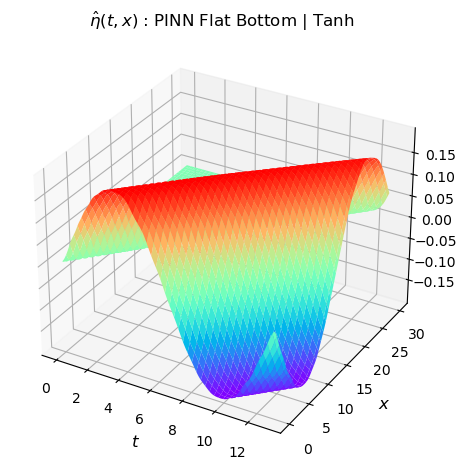

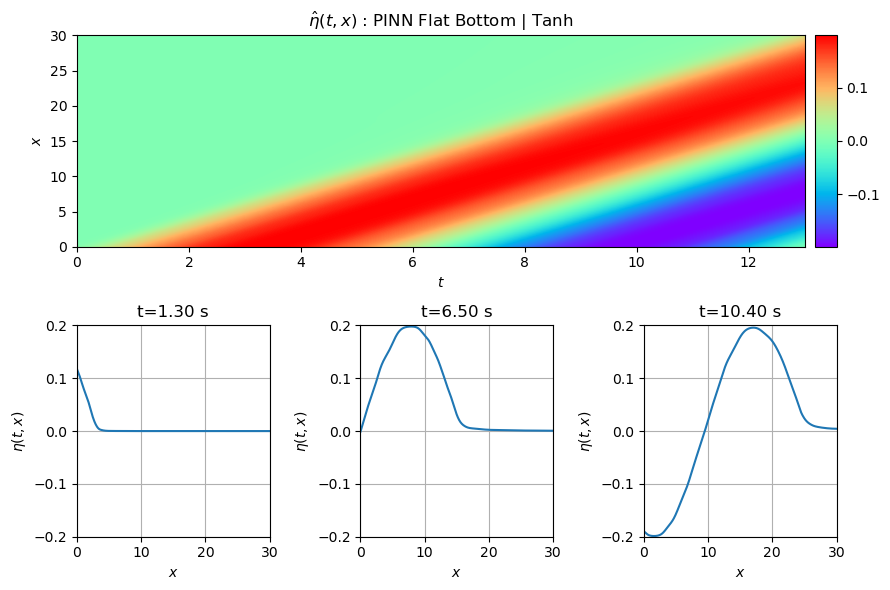

In [25]:
PINN_SWEs_FlatBottom.to('cpu')
eta_hat_FlatBottom = PINN_SWEs_FlatBottom.forward(tx_test[:, [0]], tx_test[:, [1]])[:, 1].detach().reshape(x_grid.shape)
eta_hat_FlatBottom = eta_hat_FlatBottom.numpy()
plt.rcParams['figure.dpi'] = 100
ax = plt.axes(projection='3d')
ax.plot_surface(t_grid, x_grid, eta_hat_FlatBottom, cmap='rainbow')
ax.set(xlabel=r"$t$", ylabel=r"$x$", title=r"$\hat{\eta}(t,x)$ : PINN SWEs Flat Bottom | Tanh")
ax.title.set_fontsize(12)
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
plt.tight_layout()  
plt.show()

fig = plt.figure(figsize = (9, 6))
plt.rcParams['figure.dpi'] = 125
gs = GridSpec(2, 3, figure = fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[1, 2])

result_cont = ax1.imshow(eta_hat_FlatBottom, 
                        cmap='rainbow', 
                        aspect='auto',
                        origin='lower',
                        extent=[0, T, 0, Lx]
)
divider = make_axes_locatable(ax1)
cbar_axes = divider.append_axes("right",
                                    size="3%",
                                    pad=0.1)
plt.colorbar(result_cont, cax=cbar_axes)
ax1.set(xlabel=r"$t$", ylabel=r"$x$", title=r"$\hat{\eta}(t,x)$ : PINN SWEs Flat Bottom | Tanh")

ax2.plot(x_test, eta_hat_FlatBottom[:, int((Nt+1)*0.1)])
ax2.set(title="t={:.2f} s".format(T*0.1), xlabel=r"$x$", ylabel=r"$\eta(t,x)$")
bound_plt = 0.2
ax2.set_xlim(0, Lx)
ax2.set_ylim(-bound_plt, bound_plt)
ax2.grid('true')
ax3.plot(x_test, eta_hat_FlatBottom[:, int((Nt+1)*0.5)])
ax3.set(title="t={:.2f} s".format(T*0.5), xlabel=r"$x$", ylabel=r"$\eta(t,x)$")
ax3.set_xlim(0, Lx)
ax3.set_ylim(-bound_plt, bound_plt)
ax3.grid('true')
ax4.plot(x_test, eta_hat_FlatBottom[:, int((Nt+1)*0.8)])
ax4.set(title="t={:.2f} s".format(T*0.8), xlabel=r"$x$", ylabel=r"$\eta(t,x)$")
ax4.set_xlim(0, Lx)
ax4.set_ylim(-bound_plt, bound_plt)
ax4.grid('true')
plt.tight_layout()
plt.show()